In [84]:
from SimPEG import Mesh, Utils, EM
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'save', 'inv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [64]:
csx, csy, csz = 100., 100., 100. 
ncx, ncy, ncz, npad = 32, 32, 30, 10
hx = [(csx,npad,-1.3), (csx,ncx), (csx,npad,1.3)]
hy = [(csy,npad,-1.3), (csy,ncy), (csy,npad,1.3)]
# hz = [(csz,npad,-1.4), (csz,12), (50,6),(50,6),(csz,12), (csz,npad,1.4)]
hz = [(csz,npad,-1.3), (csz,12), (50, 6)]
mesh = Mesh.TensorMesh([hx,hy,hz], 'CCN')

xr = np.linspace(-1200., 1200., 25);
XYZ = Utils.ndgrid(xr, xr, -1e0*np.ones(1));

In [65]:
blkind1 = Utils.ModelBuilder.getIndicesBlock([-900., -900., -250.], [-400., -400., -650.], mesh.gridCC)
blkind2 = Utils.ModelBuilder.getIndicesBlock([-900.,  400., -250.], [-400., 900., -650.], mesh.gridCC)
blkind3 = Utils.ModelBuilder.getIndicesBlock([400., 400., -250.], [900., 900., -650.], mesh.gridCC)
blkind4 = Utils.ModelBuilder.getIndicesBlock([400., -900., -250.], [900., -400., -650.], mesh.gridCC)
airind = mesh.gridCC[:,2]>0.
sigma = np.ones(mesh.nC)*1./100.
sigma[blkind1] = 0.1
sigma[blkind2] = 1.
sigma[blkind3] = 0.01
sigma[blkind4] = 0.001

In [66]:
topoXYZ = Utils.ndgrid(mesh.vectorNx, mesh.vectorNy, np.r_[-1.])

In [67]:
xr = np.linspace(-1200., 1200., 25)
rxlocM = Utils.ndgrid(xr-100., xr, 0.*np.ones(1))
rxlocN = Utils.ndgrid(xr+100., xr, 0.*np.ones(1))
xc1_p, yc1_p, zc1_p = -1500., 0., 0.
xc1_n, yc1_n, zc1_n = 1500., 0., 0. 
srclocA = np.r_[xc1_p, yc1_p, zc1_p] 
srclocB = np.r_[xc1_n, yc1_n, zc1_n]

In [68]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import PardisoSolver
rx = DC.Rx.Dipole(rxlocM, rxlocN)
src = DC.Src.Dipole([rx], srclocA, srclocB)

expmap = Maps.ExpMap(mesh)
m0 = np.ones_like(sigma)*np.log(1e-2)
survey = DC.Survey([src])
problem = DC.Problem3D_N(mesh, sigmaMap=expmap)
problem.Solver = PardisoSolver
problem.pair(survey)
mtrue = np.log(sigma)

# Depth weight
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()
d0 = survey.dpred(m0)
dobs = survey.makeSyntheticData(mtrue, std=0.02)

In [80]:
reshalf = 100.
geom = d0 / reshalf

In [69]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
regmap = Maps.IdentityMap(mesh)
#TODO put warning when dobs is not set!
survey.dobs = dobs
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.Wd = 1./(abs(d0)*0.02)
reg = Regularization.Simple(mesh, mapping=regmap)
reg.cell_weights = depth
opt = Optimization.InexactGaussNewton(maxIter = 5)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
reg.alpha_s = 1.
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)
sigopt = mapping*mopt

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-03-28-11-43.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.31e+02  1.57e+04  0.00e+00  1.57e+04    3.05e+03      0              
   1  1.31e+02  8.65e+02  4.82e+00  1.50e+03    3.44e+02      0              
   2  2.62e+01  3.79e+02  6.60e+00  5.52e+02    1.84e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.5717e+03
1 : |xc-x_last| = 3.3873e+00 <= tolX*(1+|x0|) = 1.2682e+02
0 :

In [71]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -7140.53
   y0: -7140.53
   z0: -7040.53
  nCx: 52
  nCy: 52
  nCz: 28
   hx: 1378.58,  1060.45,  815.73,  627.49,  482.68,  371.29,  285.61,  219.70,  169.00,  130.00,  32*100.00,  130.00,  169.00,  219.70,  285.61,  371.29,  482.68,  627.49,  815.73,  1060.45,  1378.58,
   hy: 1378.58,  1060.45,  815.73,  627.49,  482.68,  371.29,  285.61,  219.70,  169.00,  130.00,  32*100.00,  130.00,  169.00,  219.70,  285.61,  371.29,  482.68,  627.49,  815.73,  1060.45,  1378.58,
   hz: 1378.58,  1060.45,  815.73,  627.49,  482.68,  371.29,  285.61,  219.70,  169.00,  130.00,  12*100.00,  6*50.00,


In [72]:
import matplotlib
matplotlib.rcParams["font.size"] = 13
# matplotlib.rcParams["text.use"] = False

-275.0


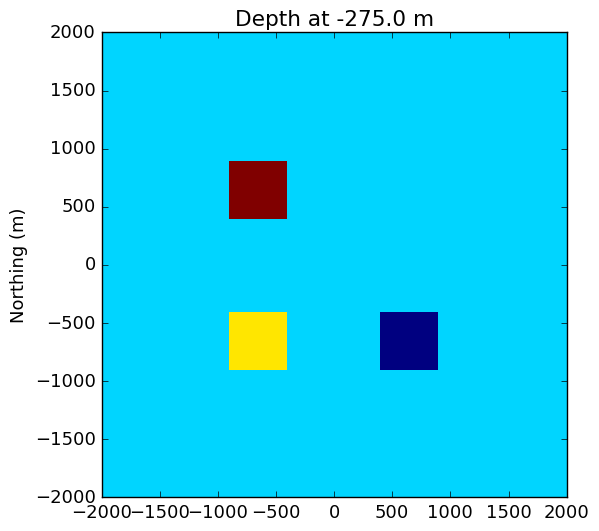

In [73]:
indz = 22
print mesh.vectorCCz[indz]
fig, ax = plt.subplots(1,1, figsize = (5*1.2,5*1.2))
mesh.plotSlice(np.log10(sigma), ax=ax, grid=False, ind=indz)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
ax.set_xlabel(" ")
# ax.plot(XYZ[:,0]+100, XYZ[:,1], 'w.')
# ax.plot(XYZ[:,0]-100, XYZ[:,1], 'r.')

-275.0
0.00316227766017 0.1


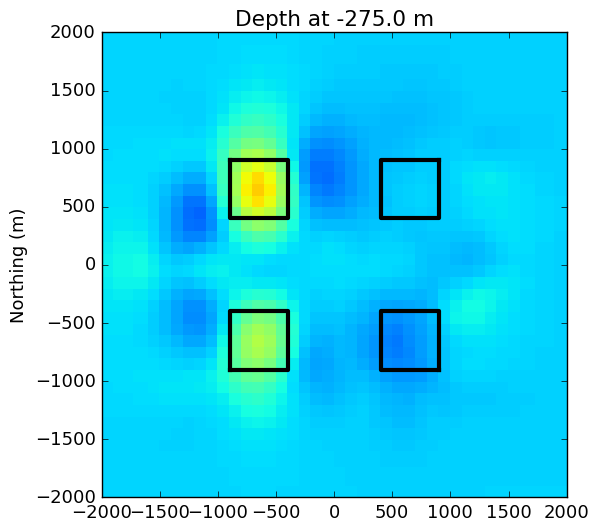

In [74]:
print mesh.vectorCCz[indz]
vmin = -2.5
vmax = -1.
print 10**vmin, 10**vmax
fig, ax = plt.subplots(1,1, figsize = (5*1.2,5*1.2))
mesh.plotSlice(np.log10(sigopt), ax=ax, grid=False, ind=indz, clim=(vmin, vmax))
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
# ax.set_xlabel("Easting (m)")
ax.set_xlabel(" ")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
rectxyx=np.r_[-900., -400., -400., -900., -900.]
rectxyy=np.r_[-900., -900., -400., -400., -900.]
ax.plot(rectxyx, rectxyy,'k-',lw=3)
ax.plot(rectxyx, -rectxyy,'k-',lw=3)
ax.plot(-rectxyx, rectxyy,'k-',lw=3)
ax.plot(-rectxyx, -rectxyy,'k-',lw=3)


750.0


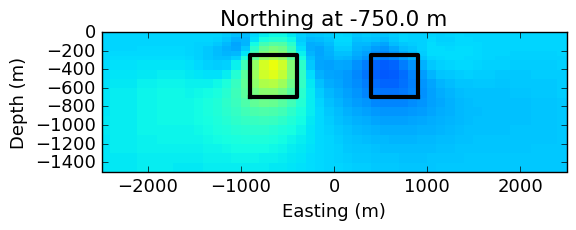

In [75]:
indy1 = 18
indy2 = 33
print mesh.vectorCCy[indy2]
fig, ax = plt.subplots(1,1, figsize = (5*1.2,1.5*1.2))
mesh.plotSlice(np.log10(sigopt), ax=ax, grid=False, normal='Y', clim=(vmin, vmax), ind = indy1)
ax.set_xlim(-2500., 2500.)
ax.set_ylim(-1500., 0.)
ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[indy1]))
ax.set_xlabel("Easting (m)")
# ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
ax.plot(-rectxzx, rectxzz,'k-',lw=3)


750.0


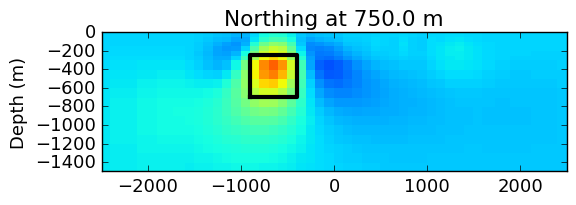

In [76]:
indy2 = 33
print mesh.vectorCCy[indy2]
fig, ax = plt.subplots(1,1, figsize = (5*1.2,1.5*1.2))
mesh.plotSlice(np.log10(sigopt), ax=ax, grid=False, normal='Y', clim=(vmin, vmax), ind = indy2)
ax.set_xlim(-2500., 2500.)
ax.set_ylim(-1500., 0.)
ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[indy2]))
# ax.set_xlabel("Easting (m)")
ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
# ax.plot(-rectxzx, rectxzz,'k-',lw=3)


In [77]:
def vizdata(dtype = "appres"):    
    if dtype=="appres":
        dataIP0 = (1./(dobs/geom)).reshape((25, 25), order='F')
        dataIP = (1./(dpred/geom)).reshape((25, 25), order='F')
    elif dtype=="potential":
        dataIP0 = (dobs).reshape((25, 25), order='F')
        dataIP = (dpred).reshape((25, 25), order='F')        
        
    fig, ax = plt.subplots(1,2, figsize = (12,4.5))
    
    X, Y = XYZ[:,0].reshape((25, 25), order='F'), XYZ[:,1].reshape((25, 25), order='F')
    vmin, vmax = dataIP0.min(), dataIP0.max()
    dat0 = ax[0].contourf(X, Y, dataIP0, 30, vmin=vmin, vmax=vmax, clim=(vmin, vmax))    
    cb0 = plt.colorbar(dat0, ax=ax[0],format='%.0e')
    dat1 = ax[1].contourf(X, Y, dataIP, 30, vmin=vmin, vmax=vmax, clim=(vmin, vmax))    
    cb1 = plt.colorbar(dat0, ax=ax[1],format='%.0e')
    if dtype=="appres":
#         cb0.set_label("Apparent resistivity (ohm-m)")
        cb1.set_label("Apparent conductivity (S/m)")
    elif dtype=="potential":
#         cb0.set_label("Voltage (V)")
        cb1.set_label("Voltage (V)")    
    ax[0].set_title("Observed data")
    ax[1].set_title("Predicted data")
    for i in range(2):
        ax[i].set_xlabel("Easting (m)")
        if i==0:
            ax[i].set_ylabel("Northing (m)")

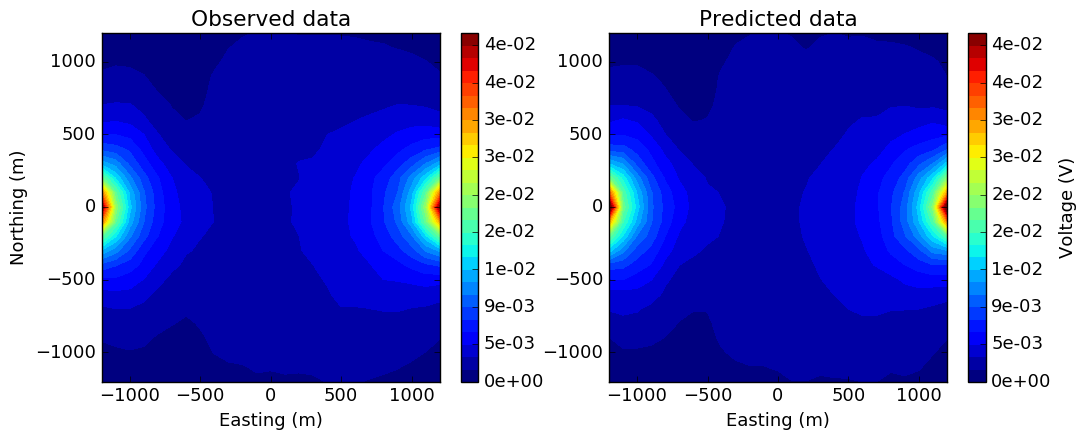

In [78]:
vizdata(dtype="potential")

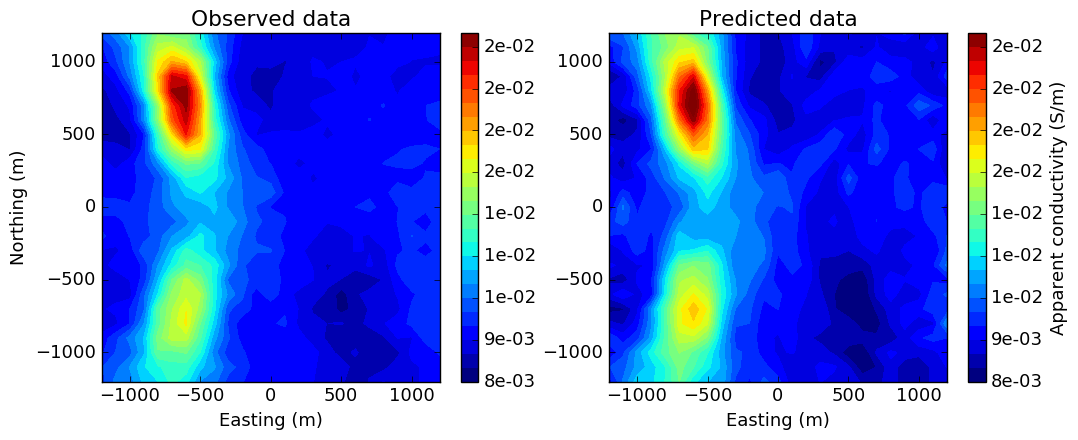

In [81]:
vizdata(dtype="appres")

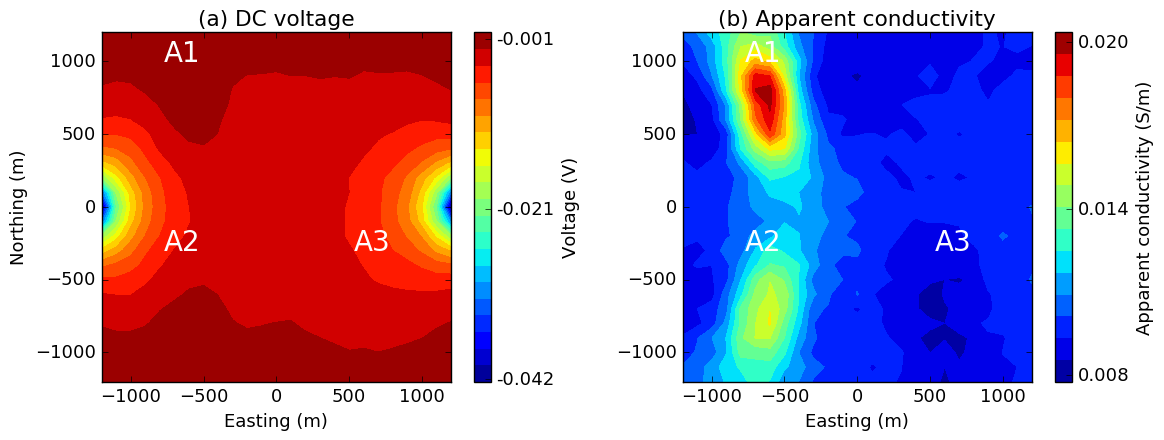

In [83]:
fig = plt.figure(figsize = (12,4.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
xr = np.linspace(-1200., 1200., 25);
XYZ = Utils.ndgrid(xr, xr, -1e0*np.ones(1));
temp = -dobs.copy()
DOBS = temp.reshape((25, 25), order='F')
appcond = (1./(dobs/geom))
APPCOND = appcond.reshape((25, 25), order='F')
X, Y = XYZ[:,0].reshape((25, 25), order='F'), XYZ[:,1].reshape((25, 25), order='F')
dat1 = ax1.contourf(X, Y, DOBS, 20)    
dat2 = ax2.contourf(X, Y, APPCOND, 20)    

cb = plt.colorbar(dat1, ax=ax1, ticks=np.linspace(temp.min(), temp.max(), 3), format="%.3f")
cb.set_label("Voltage (V)")
cb = plt.colorbar(dat2, ax=ax2, ticks=np.linspace(appcond.min(), appcond.max(), 3), format="%.3f")
cb.set_label("Apparent conductivity (S/m)")

ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax2.set_xlabel("Easting (m)")
ax1.set_title("(a) DC voltage")
ax2.set_title("(b) Apparent conductivity")
anomalies = ["A1", " ", "A2", "A3"]
x_a = np.r_[-120-650,-120+650,-120-650,-120+650]
y_a = np.r_[550, 550, -550-200, -550-200]+450.
cols = ["w", "w", "w", "w"]

for j in range(4):
    ax1.text(x_a[j], y_a[j], anomalies[j], color=cols[j], fontsize = 20)
    ax2.text(x_a[j], y_a[j], anomalies[j], color=cols[j], fontsize = 20)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.tight_layout()